## NN Adv Assignment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

### TensorFlow

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv('/content/drive/MyDrive/21기 투빅스/week6/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/21기 투빅스/week6/Test.csv')

In [ ]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train['label'].nunique()

10

In [ ]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values

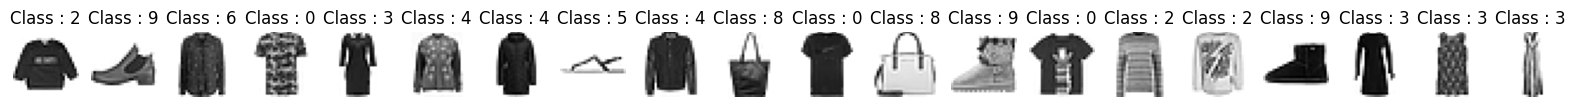

In [ ]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [6]:
X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

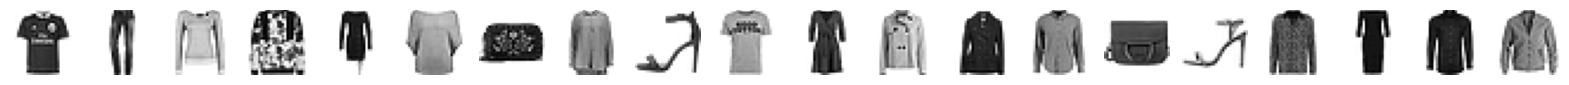

In [ ]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [8]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print(DEVICE)

cpu


In [9]:
#Batch Size는 조정 가능합니다.
BATCH_SIZE = 128
#Epoch는 고정해주세요.
EPOCHS = 15

In [10]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [11]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [12]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()

  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

## 직접 Network를 설계하고, 성능을 시험해보자.

### 참고: https://wikidocs.net/63618

In [22]:
class MyNet(nn.Module):
    def __init__(self, dropout_rate = 0.3) -> None:
        super().__init__()
        #여기에 layer들을 삽입: self.layer1 와 같이 Data Attribute로 nn 모듈의 Network 추가
        #Ex. self.layer1 = nn.Linear(100, 10)
        #자세한 것은 pytorch 공식문서 혹은 인터넷 예제 참고
        self.dropout = dropout_rate

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        #여기에 Forward 함수 삽입: __init__에서 추가한 Layer에 순전파시킴
        #Ex. x = self.layer1(x)
        x = x.view(-1, 1, 28, 28)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)   # Flatten them for FC
        x = self.layer4(x)
        x = self.fc2(x)
        return x

model = MyNet().to(DEVICE)
#적절한 optimizer를 선택: torch.optim의 적절한 Optimizer를 사용
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)
#적절한 Loss function을 선택: nn 모듈의 Function을 사용
criterion = nn.CrossEntropyLoss()

In [34]:
# dropout = 0.3
class MyNet(nn.Module):
    def __init__(self, dropout_rate = 0.3) -> None:
        super().__init__()
        #여기에 layer들을 삽입: self.layer1 와 같이 Data Attribute로 nn 모듈의 Network 추가
        #Ex. self.layer1 = nn.Linear(100, 10)
        #자세한 것은 pytorch 공식문서 혹은 인터넷 예제 참고
        self.dropout = dropout_rate

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            )

        self.fc1 = torch.nn.Linear(64 * 14 * 14, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)

        self.layer3 = torch.nn.Sequential(
            self.fc1,
            #torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            #torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout),
            #torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
            )

        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        #여기에 Forward 함수 삽입: __init__에서 추가한 Layer에 순전파시킴
        #Ex. x = self.layer1(x)
        x = x.view(-1, 1, 28, 28)
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)   # Flatten them for FC
        x = self.layer3(x)
        x = self.fc2(x)
        return x

model = MyNet().to(DEVICE)
#적절한 optimizer를 선택: torch.optim의 적절한 Optimizer를 사용
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)
#적절한 Loss function을 선택: nn 모듈의 Function을 사용
criterion = nn.CrossEntropyLoss()

In [40]:
class MyNet(nn.Module):
    def __init__(self, dropout_rate = 0.3) -> None:
        super().__init__()
        #여기에 layer들을 삽입: self.layer1 와 같이 Data Attribute로 nn 모듈의 Network 추가
        #Ex. self.layer1 = nn.Linear(100, 10)
        #자세한 것은 pytorch 공식문서 혹은 인터넷 예제 참고
        self.dropout = dropout_rate

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout))

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        self.fc1 = torch.nn.Linear(8 * 8 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)

        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout))

        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        #여기에 Forward 함수 삽입: __init__에서 추가한 Layer에 순전파시킴
        #Ex. x = self.layer1(x)
        x = x.view(-1, 1, 28, 28)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)   # Flatten them for FC
        x = self.layer4(x)
        x = self.fc2(x)
        return x

model = MyNet().to(DEVICE)
#적절한 optimizer를 선택: torch.optim의 적절한 Optimizer를 사용
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)
#적절한 Loss function을 선택: nn 모듈의 Function을 사용
criterion = nn.CrossEntropyLoss()

[EPOCH: 1], 	Train Loss: 0.4868, 	Train Accuracy: 83.25 %, 	Val Loss: 0.3052, 	Val Accuracy: 89.00 % 

[EPOCH: 2], 	Train Loss: 0.2767, 	Train Accuracy: 89.91 %, 	Val Loss: 0.2593, 	Val Accuracy: 90.58 % 

[EPOCH: 3], 	Train Loss: 0.2371, 	Train Accuracy: 91.21 %, 	Val Loss: 0.2299, 	Val Accuracy: 91.49 % 

[EPOCH: 4], 	Train Loss: 0.2083, 	Train Accuracy: 92.27 %, 	Val Loss: 0.2240, 	Val Accuracy: 91.88 % 

[EPOCH: 5], 	Train Loss: 0.1843, 	Train Accuracy: 93.09 %, 	Val Loss: 0.2171, 	Val Accuracy: 92.12 % 

[EPOCH: 6], 	Train Loss: 0.1687, 	Train Accuracy: 93.59 %, 	Val Loss: 0.2075, 	Val Accuracy: 92.70 % 

[EPOCH: 7], 	Train Loss: 0.1486, 	Train Accuracy: 94.47 %, 	Val Loss: 0.2056, 	Val Accuracy: 92.62 % 

[EPOCH: 8], 	Train Loss: 0.1370, 	Train Accuracy: 94.85 %, 	Val Loss: 0.2119, 	Val Accuracy: 92.34 % 

[EPOCH: 9], 	Train Loss: 0.1230, 	Train Accuracy: 95.35 %, 	Val Loss: 0.2241, 	Val Accuracy: 92.06 % 

[EPOCH: 10], 	Train Loss: 0.1118, 	Train Accuracy: 95.83 %, 	Val Loss: 0.

NameError: name '마' is not defined

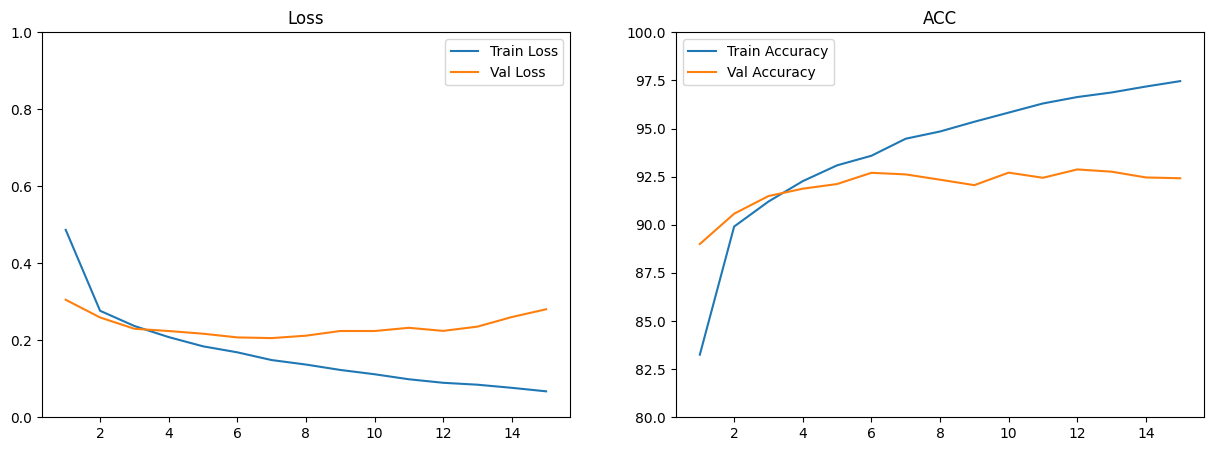

In [41]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}

  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')
plt.show()

In [49]:
# dropout = 0.5
class MyNet(nn.Module):
    def __init__(self, dropout_rate = 0.5) -> None:
        super().__init__()
        #여기에 layer들을 삽입: self.layer1 와 같이 Data Attribute로 nn 모듈의 Network 추가
        #Ex. self.layer1 = nn.Linear(100, 10)
        #자세한 것은 pytorch 공식문서 혹은 인터넷 예제 참고
        self.dropout = dropout_rate

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout))

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        self.fc1 = torch.nn.Linear(8 * 8 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)

        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout))

        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        #여기에 Forward 함수 삽입: __init__에서 추가한 Layer에 순전파시킴
        #Ex. x = self.layer1(x)
        x = x.view(-1, 1, 28, 28)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)   # Flatten them for FC
        x = self.layer4(x)
        x = self.fc2(x)
        return x

model = MyNet().to(DEVICE)
#적절한 optimizer를 선택: torch.optim의 적절한 Optimizer를 사용
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)
#적절한 Loss function을 선택: nn 모듈의 Function을 사용
criterion = nn.CrossEntropyLoss()

[EPOCH: 1], 	Train Loss: 0.5914, 	Train Accuracy: 80.07 %, 	Val Loss: 0.3203, 	Val Accuracy: 88.27 % 

[EPOCH: 2], 	Train Loss: 0.3229, 	Train Accuracy: 88.12 %, 	Val Loss: 0.2694, 	Val Accuracy: 90.42 % 

[EPOCH: 3], 	Train Loss: 0.2763, 	Train Accuracy: 89.88 %, 	Val Loss: 0.2511, 	Val Accuracy: 91.00 % 

[EPOCH: 4], 	Train Loss: 0.2501, 	Train Accuracy: 90.73 %, 	Val Loss: 0.2389, 	Val Accuracy: 91.47 % 

[EPOCH: 5], 	Train Loss: 0.2366, 	Train Accuracy: 91.22 %, 	Val Loss: 0.2430, 	Val Accuracy: 91.27 % 

[EPOCH: 6], 	Train Loss: 0.2204, 	Train Accuracy: 91.79 %, 	Val Loss: 0.2125, 	Val Accuracy: 92.33 % 

[EPOCH: 7], 	Train Loss: 0.2102, 	Train Accuracy: 92.14 %, 	Val Loss: 0.2188, 	Val Accuracy: 92.19 % 

[EPOCH: 8], 	Train Loss: 0.1986, 	Train Accuracy: 92.69 %, 	Val Loss: 0.2356, 	Val Accuracy: 91.10 % 

[EPOCH: 9], 	Train Loss: 0.1885, 	Train Accuracy: 93.04 %, 	Val Loss: 0.2148, 	Val Accuracy: 92.01 % 

[EPOCH: 10], 	Train Loss: 0.1755, 	Train Accuracy: 93.36 %, 	Val Loss: 0.

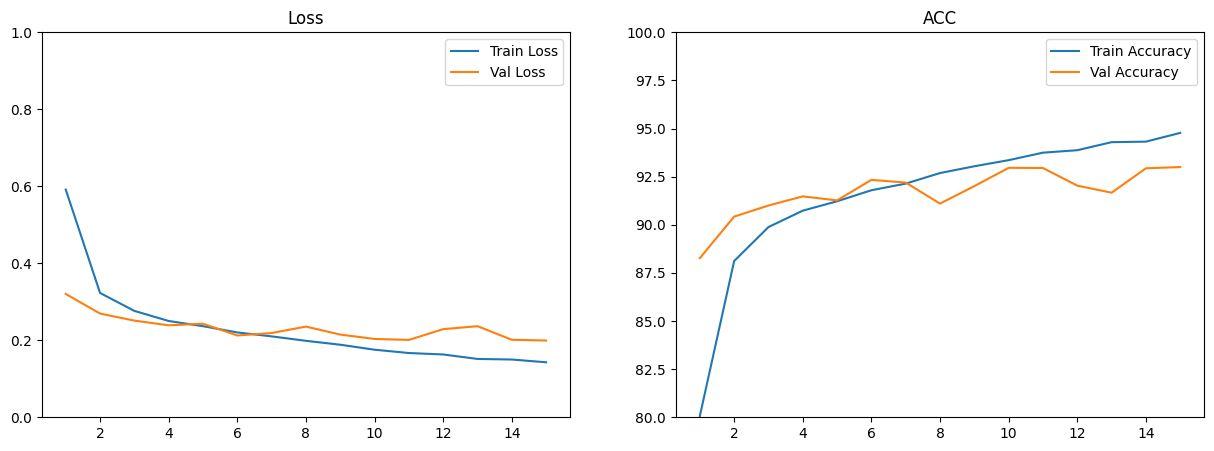

In [50]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}

  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')
plt.show()

In [71]:
# dropout = 0.5 , CosineAnnealingLR
class MyNet(nn.Module):
    def __init__(self, dropout_rate = 0.5) -> None: #  0.5로 변경
        super().__init__()
        #여기에 layer들을 삽입: self.layer1 와 같이 Data Attribute로 nn 모듈의 Network 추가
        #Ex. self.layer1 = nn.Linear(100, 10)
        #자세한 것은 pytorch 공식문서 혹은 인터넷 예제 참고
        self.dropout = dropout_rate

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout))

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        self.fc1 = torch.nn.Linear(8 * 8 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)

        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout))

        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        #여기에 Forward 함수 삽입: __init__에서 추가한 Layer에 순전파시킴
        #Ex. x = self.layer1(x)
        x = x.view(-1, 1, 28, 28)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.layer4(x)
        x = self.fc2(x)
        return x

model = MyNet().to(DEVICE)
#적절한 optimizer를 선택: torch.optim의 적절한 Optimizer를 사용
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.001) #추가
#적절한 Loss function을 선택: nn 모듈의 Function을 사용
criterion = nn.CrossEntropyLoss()

[EPOCH: 1], 	Train Loss: 0.6748, 	Train Accuracy: 77.65 %, 	Val Loss: 0.3355, 	Val Accuracy: 87.60 % 

[EPOCH: 2], 	Train Loss: 0.3445, 	Train Accuracy: 87.49 %, 	Val Loss: 0.3060, 	Val Accuracy: 88.94 % 

[EPOCH: 3], 	Train Loss: 0.2981, 	Train Accuracy: 89.11 %, 	Val Loss: 0.2752, 	Val Accuracy: 89.92 % 

[EPOCH: 4], 	Train Loss: 0.2719, 	Train Accuracy: 90.04 %, 	Val Loss: 0.2498, 	Val Accuracy: 90.95 % 

[EPOCH: 5], 	Train Loss: 0.2533, 	Train Accuracy: 90.69 %, 	Val Loss: 0.2315, 	Val Accuracy: 91.45 % 

[EPOCH: 6], 	Train Loss: 0.2377, 	Train Accuracy: 91.23 %, 	Val Loss: 0.2327, 	Val Accuracy: 91.37 % 

[EPOCH: 7], 	Train Loss: 0.2294, 	Train Accuracy: 91.47 %, 	Val Loss: 0.2215, 	Val Accuracy: 92.12 % 

[EPOCH: 8], 	Train Loss: 0.2134, 	Train Accuracy: 92.11 %, 	Val Loss: 0.2229, 	Val Accuracy: 91.90 % 

[EPOCH: 9], 	Train Loss: 0.2063, 	Train Accuracy: 92.38 %, 	Val Loss: 0.2145, 	Val Accuracy: 92.17 % 

[EPOCH: 10], 	Train Loss: 0.1988, 	Train Accuracy: 92.55 %, 	Val Loss: 0.

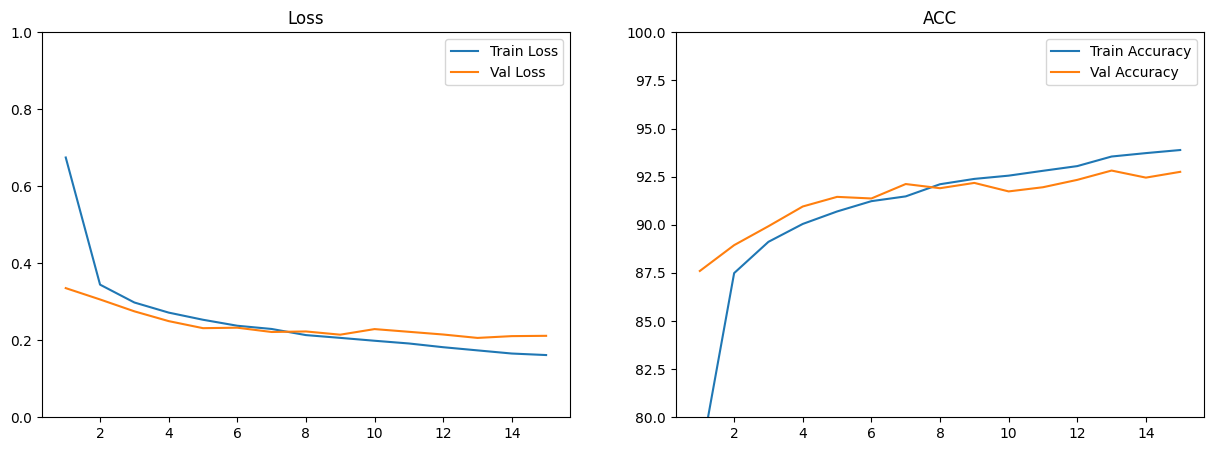

In [72]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}

  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')
plt.show()

## 결론을 작성해주세요:

In [ ]:
'''
1번 모델 : Val Accuracy: 92.42 % / Dropout = 0.3, AdamW,
2번 모델 : Val Accuracy: 93.00 % / Dropout = 0.5, AdamW,
3번 모델 : Val Accuracy: 92.75 % / Dropout = 0.5, AdamW + CosineAnnealingLR

Optimization : AdamW
    - 3번 모델에서 CosineAnnealingLR과 함께 사용한 결과, 2번 실험 결과보다 Val Accuracy가 약간 감소했다.
      2번의 결과 그래프를 보면, val loss와 val accruacy가 불안정한 모습을 보인 것과 달리,
      3번에서는 CosineAnnealingLR과를 통해 어느정도의 불안정성을 해소했다고 방증할 수 있다.

Regularization : Dropout 0.3과 0.5로 나누어 실험
    - 1번 모델(Dropout = 0.3)에서 Train 약간의 과적합이 보인다고 판단되어 2번 모델에서 0.5로 늘려 실험한 결과,
      Train Accuracy는 다소 낮아지고 Val Accuracy는 약간 향상된 것을 확인할 수 있다.
    - 이는 과적합을 해결하는 데 도움이 되었음을 알 수 있다.

Initialization : Xaiver uniform Initialization을 선형 변환 레이어에 적용하였다.
                 Xaiver normal Initialization도 적용해보았으나, 매우 낮은 수치를 보여 uniform 형태로 설정하였다.

Normalization : Batch Normalization 사용하여 네트워크의 안정성과 속도를 높였다

최종 실험 결과, 2번 모델에서 에포크 15로 설정하였을 때, 93.0%로 가장 높은 검증 정확도를 보였다.
'''